In [32]:
import json
import os
import pickle
import re
import string
import itertools
from tqdm import tqdm
from __future__ import print_function
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn import metrics
import numpy as np
from matplotlib import pyplot as plt


plt.style.use('dark_background')

In [46]:
def read_data(filename,num_tweets):
    
    def in_washington(location):
        washington_words = ['Seattle','Washington','WA','Kirkland','Bellevue','Redmond']
        washington_anti = ['DC','D.C','D.C.']
        if (any(word in location for word in washington_words) and 
            not any(word in location for word in washington_anti)):
            return True
        return False
            
    def in_massachusetts(location):
        massachusetts_words = ['MA','Massachusetts','Boston','Worcester','Springfield',
                               'Lowell','Arlington','Bedford','Brockton','Quincy','Lynn',
                               'Northampton','Cambridge']
        massachusetts_anti = ['Ohio']
            
        if (any(word in location for word in massachusetts_words) and 
            not any(word in location for word in massachusetts_anti)):
            return True
        return False        
        
    data = []
    labels = []
    with open(filename,'r') as fp:
        for index,line in tqdm(enumerate(fp),total=num_tweets):
            entry = json.loads(line)
            location = entry['tweet']['user']['location']
            if(in_washington(location)):
                data.append(entry['title'])
                labels.append(0)
            elif(in_massachusetts(location)):
                data.append(entry['title'])
                labels.append(1)
    return data,labels

class TweetPreprocessor(object):
    def __init__(self):
        self.snowball_stemmer = SnowballStemmer("english")

    def __call__(self, tweet):
        tweet = re.sub('[-.,></?;:(){}!@#$%^&*_=~`]', ' ', tweet)
        tweet = ''.join(ch for ch in tweet if ch not in string.punctuation)
        tweet = ''.join(ch for ch in tweet if ord(ch) < 128)  # remove non-ascii characters
        tweet = tweet.lower()
        words = tweet.split()
        processed_tweet = [self.snowball_stemmer.stem(word) for word in words \
                           if word not in text.ENGLISH_STOP_WORDS]

        return processed_tweet

def get_vectorizer():
    return CountVectorizer(tokenizer=TweetPreprocessor(),
        lowercase=True,min_df = 2,max_df = 0.99)

def get_tfidf_transformer():
    return TfidfTransformer(norm='l2',sublinear_tf=True)

def get_lsi(dim=50):
    return TruncatedSVD(n_components=dim)

In [47]:
def get_data(filename,num_tweets,dataset='train',precomputed=False):
    if(not precomputed):
        if not os.path.exists(os.path.join('data',dataset,'part2')):
            os.makedirs(os.path.join('data',dataset,'part2'))
        tweets,labels = read_data(os.path.join('data',dataset,filename),num_tweets)
        name = filename[:filename.index('.')]+'.pkl'
        pickle_filename = os.path.join('data',dataset,'part2',name)
        with(open(pickle_filename,'wb')) as fp:
            pickle.dump([tweets,labels],fp,protocol=2)
    else:
        name = filename[:filename.index('.')]+'.pkl'
        pickle_filename = os.path.join('data',dataset,'part2',name)
        with(open(pickle_filename,'rb')) as fp:
            tweets,labels = pickle.load(fp)
    return tweets,labels

print('Loading #superbowl tweets')
tweets,labels = get_data('tweets_#superbowl.txt',1348767,precomputed=False)
print('Number of tweets =',len(tweets))

Loading #superbowl tweets


100%|███████████████████████████████████████████████| 1348767/1348767 [11:23<00:00, 1974.22it/s]


Number of tweets = 46939


In [48]:
load_lsi = False
target_names = ['Washington','Massachusetts']
pickleFile = os.path.join('data','train','part2','lsi.pkl')

if(not load_lsi):
    pipeline = Pipeline([
            ('vectorize', get_vectorizer()),
            ('tf-idf', get_tfidf_transformer()),
            ('lsi', get_lsi(dim=100))])
    
    print("Computing the LSI representation of the dataset")
    tweets = pipeline.fit_transform(tweets)
    tweets_train,tweets_test,train_labels,test_labels = train_test_split(tweets,labels,
                                                                     test_size=0.15,
                                                                     random_state=72)
    train_labels = np.array(train_labels)
    test_labels = np.array(test_labels)
    with open(pickleFile,'wb') as fp:
        pickle.dump({'tweets_train':tweets_train,'tweets_test':tweets_test,
                     'train_labels':train_labels,'test_labels':test_labels},fp)
else:
    with open(pickleFile,'rb') as fp:
        pickle_data = pickle.load(fp)
        tweets_train = pickle_data['tweets_train']
        tweets_test = pickle_data['tweets_test']
        train_labels = pickle_data['train_labels']
        test_labels = pickle_data['test_labels']
        
print('Shape of Training Data =', tweets_train.shape)
print('Shape of Testing Data =', tweets_test.shape)
print('# of Washington Labels in training=', sum(train_labels==0))
print('# of Massachusetts Labels in training=', sum(train_labels==1))
print('# of Washington Labels in testing=', sum(test_labels==0))
print('# of Massachusetts Labels in testing=', sum(test_labels==1))

Computing the LSI representation of the dataset
Shape of Training Data = (39898L, 100L)
Shape of Testing Data = (7041L, 100L)
# of Washington Labels in training= 17386
# of Massachusetts Labels in training= 22512
# of Washington Labels in testing= 3022
# of Massachusetts Labels in testing= 4019


#### Visualization of Separability

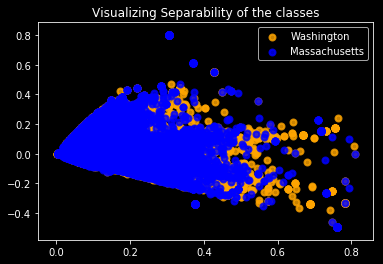

In [38]:
def visualize(data,labels,target_names):
    #Visualization
    colors = ['orange', 'blue']
    for color, i, target_name in zip(colors, [0,1], target_names):
        plt.scatter(data[labels == i, 0], data[labels == i, 1], color=color, alpha=.8, lw=2,
                    label=target_name)
    plt.legend(loc='best', labels=target_names)
    plt.title('Visualizing Separability of the classes')
    plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Spectral):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig=plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%.2f"%cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def plot_roc_curve(fpr,tpr,algo):
    roc_auc = metrics.auc(fpr,tpr)
    fig=plt.figure(figsize=(8,8))
    plt.title(''.join(['ROC - ',algo]))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot(fpr,tpr,'b',label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.show()
    
target_names = ['Washington','Massachusetts']
visualize_data = get_lsi(dim=2).fit_transform(tweets_train)    
visualize(visualize_data,train_labels,target_names)

In [39]:
def classify(model,X_train,X_test,y_train,y_test,classifier):
    target_names = ['Washington','Massachusetts']
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Accuracy of model =',metrics.accuracy_score(y_pred,y_test)*100)
    print('Precision of model =',metrics.precision_score(y_pred,y_test,average='macro')*100)
    print('Recall of model =',metrics.recall_score(y_pred,y_test,average='macro')*100)
    cfm = metrics.confusion_matrix(y_pred,y_test)
    plot_confusion_matrix(cfm,target_names)
    y_pred = model.predict_proba(X_test)
    fpr,tpr,_ = metrics.roc_curve(y_test, y_pred[:,1])
    plot_roc_curve(fpr,tpr,classifier)

#### Naive Bayes - Bernoulli

Accuracy of model = 75.273398665
Precision of model = 73.4520088152
Recall of model = 75.6712610383


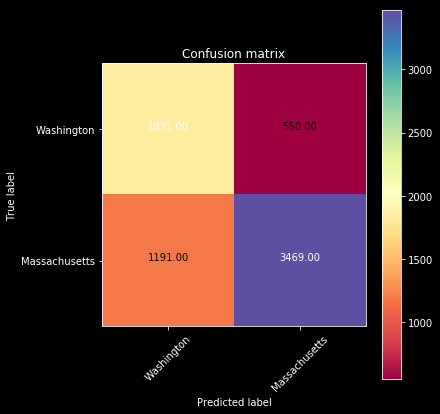

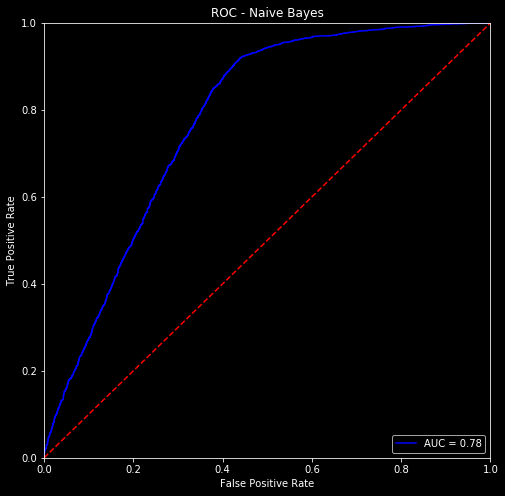

In [49]:
classify(BernoulliNB(),tweets_train,tweets_test,train_labels,test_labels,'Naive Bayes')

#### SVM

Accuracy of model = 0.701097560976
Precision of model = 0.469797016385
Recall of model = 0.871597096189


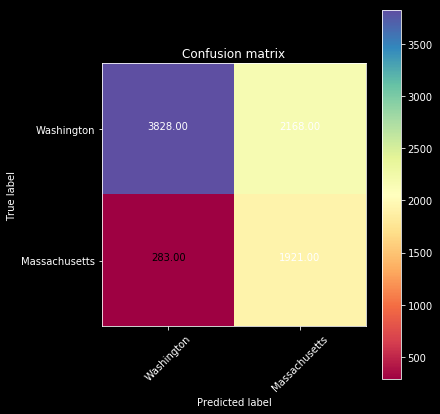

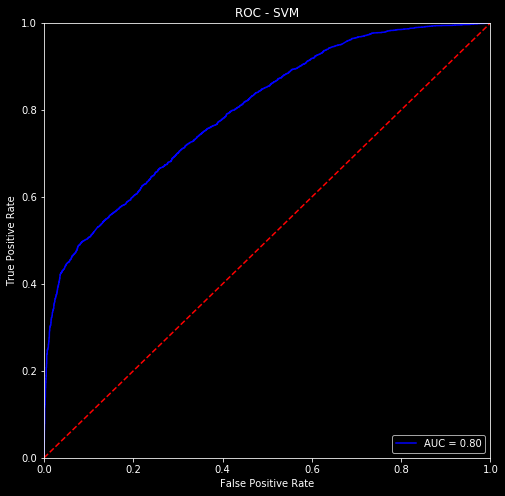

In [30]:
classify(svm.SVC(C=10,probability=True),
         tweets_train,tweets_test,
         train_labels,test_labels,
         'SVM')

#### AdaBoost

Accuracy of model = 0.715174243117
Precision of model = 0.610805860806
Recall of model = 0.771276595745


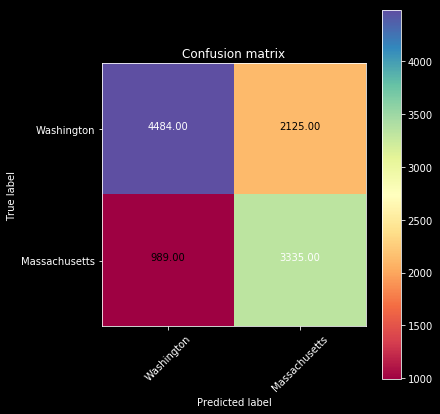

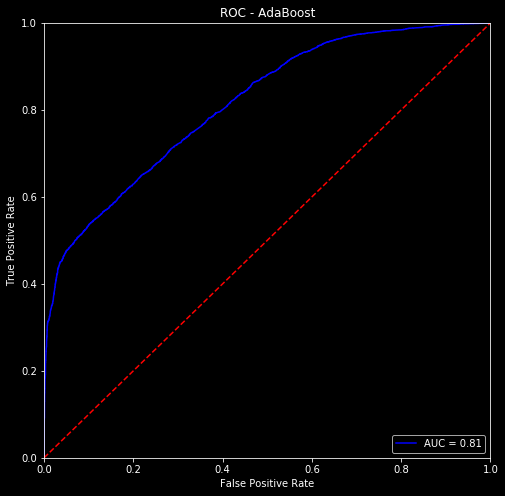

In [22]:
classify(AdaBoostClassifier(),
         tweets_train,tweets_test,
         train_labels,test_labels,
         'AdaBoost')

#### Random Forest Classifier

Accuracy of model = 70.7948413061
Precision of model = 70.774342443
Recall of model = 73.5863127635


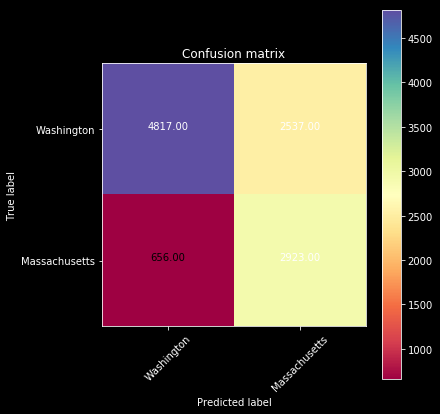

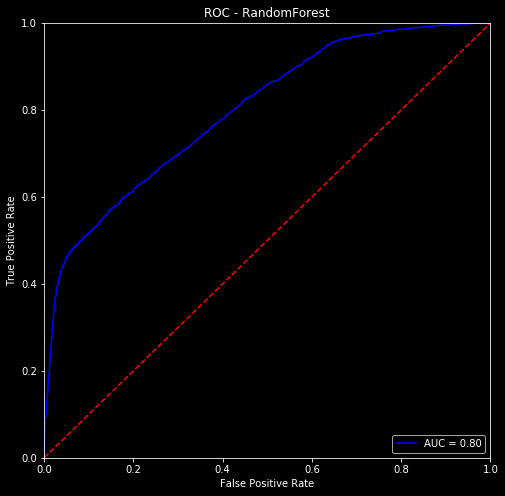

In [28]:
classify(RandomForestClassifier(max_depth=5, n_estimators=10),
         tweets_train,tweets_test,
         train_labels,test_labels,
         'RandomForest')

#### Neural Network

Accuracy of model = 0.706341463415
Precision of model = 0.62313524089
Recall of model = 0.746120058565


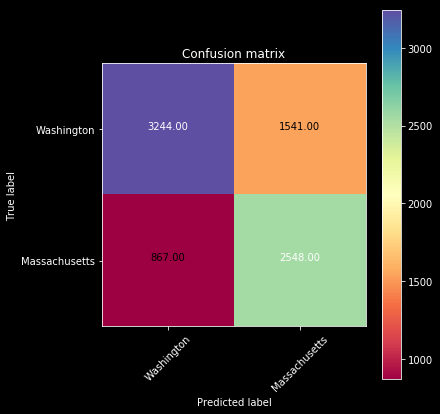

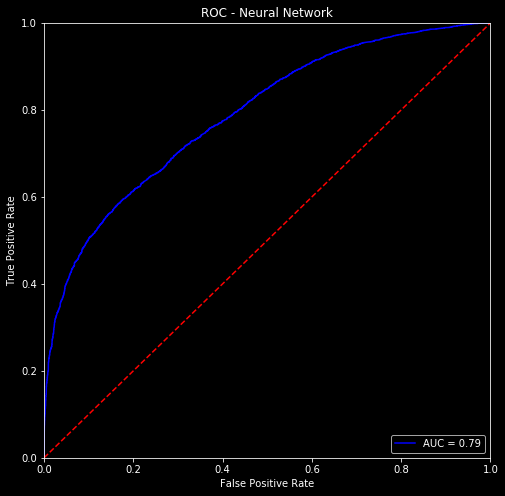

In [28]:
classify(MLPClassifier(hidden_layer_sizes=[100],activation='relu',batch_size=256),
         tweets_train,tweets_test,
         train_labels,test_labels,
         'Neural Network')

#### Logistic Regression

Accuracy of model = 79.264309047
Precision of model = 76.6811154626
Recall of model = 82.4381898864


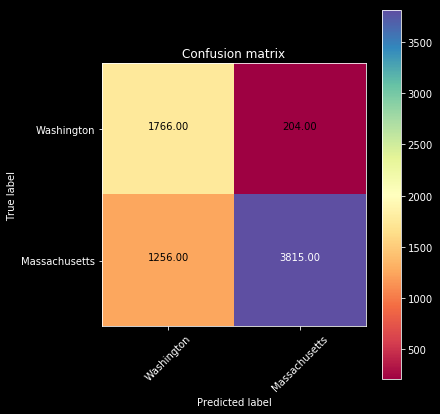

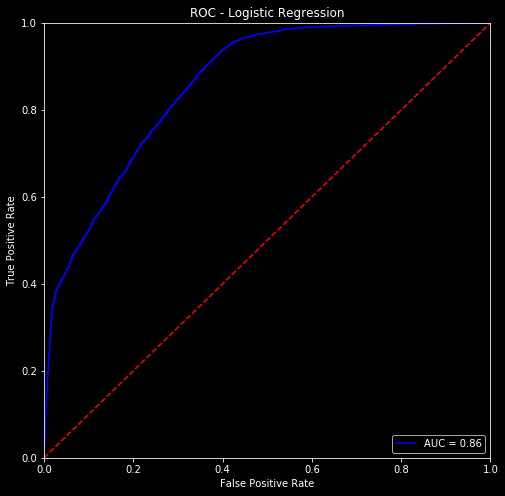

In [50]:
classify(LogisticRegression(),
         tweets_train,tweets_test,
         train_labels,test_labels,
         'Logistic Regression')

#### SVM (Do not execute! - training time too long)

# Tuning hyper-parameters for accuracy - lsi
Best parameters set found on development set:
{'kernel': 'rbf', 'C': 10}
Grid scores on development set:
0.540 (+/-0.000) for {'kernel': 'rbf', 'C': 0.01}
0.643 (+/-0.004) for {'kernel': 'linear', 'C': 0.01}
0.540 (+/-0.000) for {'kernel': 'poly', 'C': 0.01}
0.642 (+/-0.004) for {'kernel': 'rbf', 'C': 0.1}
0.683 (+/-0.005) for {'kernel': 'linear', 'C': 0.1}
0.540 (+/-0.000) for {'kernel': 'poly', 'C': 0.1}
0.683 (+/-0.005) for {'kernel': 'rbf', 'C': 1}
0.687 (+/-0.006) for {'kernel': 'linear', 'C': 1}
0.540 (+/-0.000) for {'kernel': 'poly', 'C': 1}
0.688 (+/-0.005) for {'kernel': 'rbf', 'C': 10}
0.687 (+/-0.006) for {'kernel': 'linear', 'C': 10}
0.540 (+/-0.000) for {'kernel': 'poly', 'C': 10}
Detailed classification report:
Accuracy of model = 0.688025774118
Precision of model = 0.8465085639
Recall of model = 0.668053028334


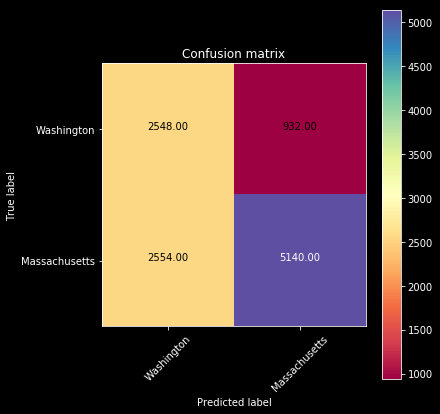

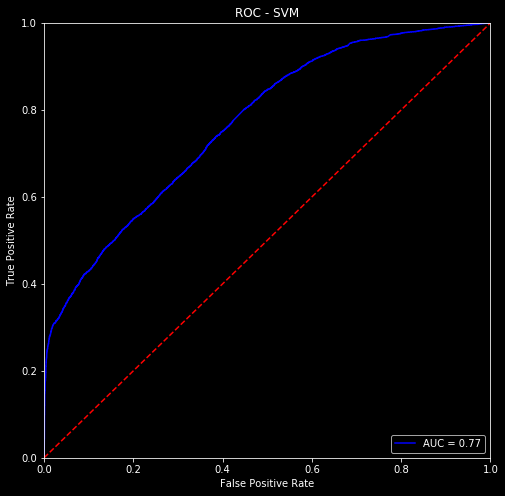

In [11]:
def svm_function(X_train,X_test,y_train,y_test,target_names):
    tuned_parameters = [{'kernel': ['rbf','linear','poly']}]
    scores = ['accuracy']
    for score in scores:
        print("# Tuning hyper-parameters for {0}".format(score))
        clf = GridSearchCV(svm.SVC(C=10,probability=True), tuned_parameters, cv=1,
                           scoring=score, n_jobs=5)
        clf.fit(X_train, y_train)

        print("Best parameters set found on development set:")
        print(clf.best_params_)
        print("Grid scores on development set:")
        for params, mean_score, scores in clf.grid_scores_:
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean_score, scores.std() * 2, params))
        print("Detailed classification report:")
        y_pred = clf.predict(X_test)
        print('Accuracy of model =',metrics.accuracy_score(y_pred,y_test))
        print('Precision of model =',metrics.precision_score(y_pred,y_test))
        print('Recall of model =',metrics.recall_score(y_pred,y_test))
        cfm = metrics.confusion_matrix(y_pred,y_test)
        plot_confusion_matrix(cfm,target_names)
        y_preds = clf.predict_proba(X_test)
        fpr,tpr,_ = metrics.roc_curve(y_test, y_preds[:,1])
        plot_roc_curve(fpr,tpr,'Cross-validated SVM')

svm_function(tweets_train,tweets_test,train_labels,test_labels,target_names)